In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install scikit-optimize

In [ ]:
import pandas as pd
import numpy as np

#Progress bars
from tqdm import tqdm
tqdm.pandas()

#Paralelize pandas apply on multiple cores

import matplotlib.pyplot as plt

from sklearn import metrics

import seaborn as sns

#One-hot encodding
from sklearn.preprocessing import LabelBinarizer

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Embedding, GlobalMaxPooling1D, Conv1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import binary_crossentropy
from keras.models import load_model

from numpy.random import seed

from sklearn.model_selection import train_test_split

from gensim.models import KeyedVectors

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [ ]:
df = pd.read_pickle('/content/drive/Shareddrives/DS4A_Fakenews/data/clean_data/clean_news.pickle')#.reset_index()
df = df.dropna()

In [ ]:
df["type"].value_counts()

fake    24459
true    21417
bias      352
Name: type, dtype: int64

LABELS <br>
bias [1 0 0] <br>
fake [0 1 0] <br>
true [0 0 1] <br>

**Drop the bias type because its data size is too small**

In [ ]:
df = df[df["type"] != "bias"]
df = df.reset_index().drop("index", axis=1)
df.head()

,title,text,type,clean_text,vectorized_clean_text,vectorized_title,one_hot_label
0,community still financing protecting terrorist...,\n21st Century Wire says… \nAs western media o...,fake,st century wire western media outlets like new...,"[23764, 3343, 6333, 2749, 538, 7527, 87, 65, 3...","[339, 151, 2647, 4253, 3511, 852, 0, 0, 0, 0, ...","[0, 1, 0]"
1,director leaked memo explains reopening email ...,\n21st Century Wire says… \n21WIRE reported on...,fake,st century wire wire reported surprising annou...,"[23764, 3343, 6333, 6333, 343, 4543, 1744, 47,...","[445, 8507, 7490, 4107, 15821, 2227, 288, 0, 0...","[0, 1, 0]"
2,behind new probe emails,\nIn a stunning turn of events 11 days before ...,fake,stunning turn events days presidential electio...,"[5682, 749, 696, 255, 1929, 631, 340, 915, 222...","[474, 65, 4030, 9451, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 1, 0]"
3,party corruption campaign directly tied disgra...,A tidal wave of revelations is pouring out of ...,fake,tidal wave revelations pouring campaign presid...,"[33871, 3512, 12193, 11059, 537, 1929, 631, 61...","[447, 2873, 537, 1595, 1544, 21356, 4158, 0, 0...","[0, 1, 0]"
4,hack hoax biggest lie election season,"November 1, 2016 By 21wire 4 Comments \nPatric...",fake,wire comments st century wire longer soap oper...,"[6333, 691, 23764, 3343, 6333, 951, 13293, 100...","[19787, 17820, 724, 4678, 631, 114, 0, 0, 0, 0...","[0, 1, 0]"


In [ ]:
df["type"].value_counts()

fake    24459
true    21417
Name: type, dtype: int64

In [ ]:
# redo the one-hot encoding as throwing away the bias
encoder = LabelBinarizer().fit(list(df["type"]))
df["one_hot_label"] = df.apply(lambda r: encoder.transform([r['type']])[0], axis=1)
df.head()

,title,text,type,clean_text,vectorized_clean_text,vectorized_title,one_hot_label
0,community still financing protecting terrorist...,\n21st Century Wire says… \nAs western media o...,fake,st century wire western media outlets like new...,"[23764, 3343, 6333, 2749, 538, 7527, 87, 65, 3...","[339, 151, 2647, 4253, 3511, 852, 0, 0, 0, 0, ...",[0]
1,director leaked memo explains reopening email ...,\n21st Century Wire says… \n21WIRE reported on...,fake,st century wire wire reported surprising annou...,"[23764, 3343, 6333, 6333, 343, 4543, 1744, 47,...","[445, 8507, 7490, 4107, 15821, 2227, 288, 0, 0...",[0]
2,behind new probe emails,\nIn a stunning turn of events 11 days before ...,fake,stunning turn events days presidential electio...,"[5682, 749, 696, 255, 1929, 631, 340, 915, 222...","[474, 65, 4030, 9451, 0, 0, 0, 0, 0, 0, 0, 0]",[0]
3,party corruption campaign directly tied disgra...,A tidal wave of revelations is pouring out of ...,fake,tidal wave revelations pouring campaign presid...,"[33871, 3512, 12193, 11059, 537, 1929, 631, 61...","[447, 2873, 537, 1595, 1544, 21356, 4158, 0, 0...",[0]
4,hack hoax biggest lie election season,"November 1, 2016 By 21wire 4 Comments \nPatric...",fake,wire comments st century wire longer soap oper...,"[6333, 691, 23764, 3343, 6333, 951, 13293, 100...","[19787, 17820, 724, 4678, 631, 114, 0, 0, 0, 0...",[0]


In [ ]:
print("LABELS")
enc = encoder.transform(encoder.classes_)
for x, y in zip(encoder.classes_, enc):
    print(x, y)

LABELS
fake [0]
true [1]


In [ ]:
df["one_hot_label"].value_counts()

[0]    24459
[1]    21417
Name: one_hot_label, dtype: int64

In [ ]:
df["type"].value_counts()

fake    24459
true    21417
Name: type, dtype: int64

In [ ]:
len_text = len(df["vectorized_clean_text"][0])
len_title = len(df['vectorized_title'][0])

print("Max len content: {}".format(len_text))
print("Max len title: {}".format(len_title))

Max len content: 523
Max len title: 12


https://cnvrg.io/cnn-sentence-classification/#:~:text=Convolutional%20Neural%20Networks%20applied%20to,like%20we%20have%20done%20above.

Split the data into train, validation, testing: <br>
test :20% <br>
train: 72%<br>
validation: 8%

In [ ]:
docs = df[["vectorized_clean_text", "vectorized_title"]]
labels = df["one_hot_label"]


# test :20%
# train: 72%
# validation: 8%

# Splitting into train and test sets
X_train, X_test , y_train, y_test = train_test_split(docs, labels , test_size = 0.20, random_state = 42)

# Splitting the train data further into train and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=42)


In [ ]:
X_train

,vectorized_clean_text,vectorized_title
4703,"[537, 25752, 7830, 266, 31787, 45, 283, 162, 1...","[25752, 3853, 197, 1004, 537, 3102, 7500, 95, ..."
22646,"[1070, 2275, 251, 2837, 746, 0, 0, 0, 0, 0, 0,...","[2837, 1070, 4531, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1352,"[6370, 5707, 152, 40718, 113, 7504, 603, 652, ...","[25752, 1926, 852, 7504, 21443, 25561, 14756, ..."
42596,"[457, 1080, 7650, 266, 10614, 3366, 111, 1313,...","[1080, 7650, 115, 21625, 1313, 1591, 152, 353,..."
23913,"[348, 25752, 213, 15134, 4161, 3608, 536, 229,...","[4715, 555, 1059, 25752, 4161, 8124, 536, 0, 0..."
...,...,...
23266,"[23764, 3343, 6333, 115, 865, 3133, 538, 11350...","[243, 582, 25752, 5811, 11120, 2819, 1219, 311..."
21721,"[196, 509, 10594, 180, 33149, 5554, 0, 0, 0, 0...","[33149, 25752, 1908, 20057, 14619, 20173, 739,..."
28031,"[25928, 1058, 164, 16943, 754, 2151, 956, 9, 1...","[164, 4264, 115, 1723, 75, 142, 3761, 671, 715..."
44104,"[13473, 447, 383, 238, 2506, 969, 447, 9, 3429...","[13473, 447, 3111, 2655, 473, 969, 0, 0, 0, 0,..."


In [ ]:
# Extract the title and content input data for train, validation, and test sets
X_train_title = X_train['vectorized_title']
X_train_text = X_train['vectorized_clean_text']

X_valid_title = X_valid['vectorized_title']
X_valid_text = X_valid['vectorized_clean_text']

X_test_title = X_test['vectorized_title']
X_test_text = X_test['vectorized_clean_text']


In [ ]:
# Create the train, validation, and test sets
train_fit = [np.asarray(X_train_title.tolist()),
             np.asarray(X_train_text.tolist())]

valid_fit = [np.asarray(X_valid_title.tolist()),
             np.asarray(X_valid_text.tolist())]

test_fit = [np.asarray(X_test_title.tolist()),
             np.asarray(X_test_text.tolist())]

In [ ]:
#Optimum params for CNN network
params_cnn = {
    'lr': 0.007112020384325484,
    'momentum': 0.8922306516546425,
    'dropout1': 0.45425308114898033,
    'dropout2': 0.3925741186212217,
    'filters1Title': 103,
    'denseTitle': 117,
    'filtersContent': 183,
    'denseContent': 104
}

In [ ]:
#  Hyperparameters Optimization.
# https://cnvrg.io/cnn-sentence-classification/#:~:text=Convolutional%20Neural%20Networks%20applied%20to,like%20we%20have%20done%20above.

In [ ]:
seed(50)
# Set random seed for reproducibility
tf.random.set_seed(50)
# clears the current Keras session
keras.backend.clear_session()

In [ ]:
# Load the pre-trained word vectors
word_model = KeyedVectors.load_word2vec_format("/content/drive/Shareddrives/DS4A_Fakenews/data/GoogleNews-vectors-negative300.bin",
                                          binary=True, limit=50000)

In [ ]:
# initializes an empty numpy array to store the word embeddings
embed_mat = np.zeros((50000, 300))
for i, key in enumerate(word_model.key_to_index):
    embed_mat[i] = word_model.get_vector(key)


The code snippet you provided builds a neural network model using the Keras library. Here's a breakdown of the model architecture:

1. Input layers:
   - `title_input`: Input layer for the title data with a shape of `(len_title,)`.
   - `content_input`: Input layer for the content data with a shape of `(len_text,)`.

2. Embedding layers:
   - `inp`: Embedding layer for the title input, which maps each word index to a dense vector representation of size 300.
   - `inp2`: Embedding layer for the content input, which also maps each word index to a dense vector representation of size 300.

3. Convolutional layers for title input:
   - `x`: Conv1D layer with 5 filters, a kernel size of 4, and a stride of 2. The activation function used is ReLU.
   - `x`: MaxPooling1D layer with a pool size of 2.

4. Convolutional layers for content input:
   - `x2`: Conv1D layer with 40 filters, a kernel size of 16, and a stride of 2. The activation function used is ReLU.
   - `x2`: MaxPooling1D layer with a pool size of 4.

   *Additionally, there is an extra set of convolutional and pooling layers for the content input:*
   - `x2`: Conv1D layer with 80 filters, a kernel size of 16, and a stride of 4. The activation function used is ReLU.
   - `x2`: MaxPooling1D layer with a pool size of 4.

5. Flattening layers:
   - `x`: Flattening layer after the title convolutional layers.
   - `x2`: Flattening layer after the content convolutional layers.

6. Dense layers:
   - `x`: Dense layer with 50 units and ReLU activation applied to the concatenated outputs of the title and content branches.
   - `x2`: Dense layer with 100 units and ReLU activation applied to the content branch.

7. Merging layers:
   - `x`: Concatenation layer that merges the outputs of the title and content branches.

8. Additional dense layers:
   - `x`: Dense layer with 50 units and ReLU activation applied to the merged output.
   - Dropout layer with a dropout rate of 0.2.
   - Dense layer with 50 units and ReLU activation.
   - Another dropout layer with a dropout rate of 0.2.

9. Output layer:
   - `out`: Dense layer with 1 unit and sigmoid activation, representing the binary classification output.

10. Model compilation:
    - The model is compiled using the RMSprop optimizer, binary cross-entropy loss function, and accuracy metric.

11. `model.summary()`: This line prints a summary of the model architecture, displaying the layers, shapes, and number of parameters.

This model combines both title and content inputs using convolutional and dense layers, followed by an output layer for binary classification.

# **Use same model and parameters from this webpage**:
https://github.com/AIRLegend/fakenews/blob/master/notebooks/Train_Colab_Binary.ipynb

In [ ]:
#input_title
title_input = keras.layers.Input(shape=(len_title,), name='title_input')
inp = keras.layers.Embedding(output_dim=300, input_dim=50000,
                         weights=[embed_mat], trainable=False, name='embed_title')(title_input)

x = keras.layers.Conv1D(filters = 5, kernel_size=4, strides=2, activation='relu', name='Conv1Title')(inp)
x = keras.layers.MaxPool1D(pool_size = 2, name='Pool1Title')(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(50, activation='relu', name='Dense1Title', kernel_regularizer='l2')(x)

#input_content
content_input = keras.layers.Input(shape=(len_text,), name='content_input')
inp2 = keras.layers.Embedding(output_dim=300, input_dim=50000,
                         weights=[embed_mat], trainable=False, name='embed_content')(content_input)
x2 = keras.layers.Conv1D(filters = 40, kernel_size = 16, strides = 2, activation='relu', name='Conv1Content')(inp2)
x2 = keras.layers.MaxPool1D(pool_size = 4, name='Pool1Content')(x2)

#Added
x2 = keras.layers.Conv1D(filters = 80, kernel_size = 16, strides = 4, activation='relu', name='Conv2Content')(inp2)
x2 = keras.layers.MaxPool1D(pool_size = 4, name='Pool2Content')(x2)
#

x2 = keras.layers.Flatten()(x2)
x2 = keras.layers.Dense(100, activation='relu', kernel_regularizer='l2', name='Dense1Content')(x2)


#Merge
x = keras.layers.concatenate([x, x2])

#Common part
x = keras.layers.Dense(50, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(50, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)
out = keras.layers.Dense(1, activation='sigmoid')(x)


#Build model
cnn_model_old = keras.models.Model(inputs=[title_input, content_input], outputs=[out])

# Default learning rate is 0.001
cnn_model_old.compile(keras.optimizers.RMSprop(), loss='binary_crossentropy', metrics=['acc'])

cnn_model_old.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 title_input (InputLayer)       [(None, 12)]         0           []                               
                                                                                                  
 content_input (InputLayer)     [(None, 523)]        0           []                               
                                                                                                  
 embed_title (Embedding)        (None, 12, 300)      15000000    ['title_input[0][0]']            
                                                                                                  
 embed_content (Embedding)      (None, 523, 300)     15000000    ['content_input[0][0]']          
                                                                                              

In [ ]:
hist = cnn_model_old.fit(x=train_fit, y=np.asarray(y_train.tolist()), batch_size=128, epochs=20,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, min_delta = 0.1)],
          validation_data=(valid_fit, np.asarray(y_valid.tolist())))

Epoch 1/20
259/259 [==============================] - 8s 21ms/step - loss: 0.4621 - acc: 0.8952 - val_loss: 0.1426 - val_acc: 0.9619
Epoch 2/20
259/259 [==============================] - 5s 21ms/step - loss: 0.1171 - acc: 0.9714 - val_loss: 0.1736 - val_acc: 0.9493
Epoch 3/20
259/259 [==============================] - 5s 19ms/step - loss: 0.0610 - acc: 0.9875 - val_loss: 0.1959 - val_acc: 0.9531


In [ ]:
cnn_model_old.save('/content/drive/Shareddrives/DS4A_Fakenews/notebook/model/old_cnn_model.h5')

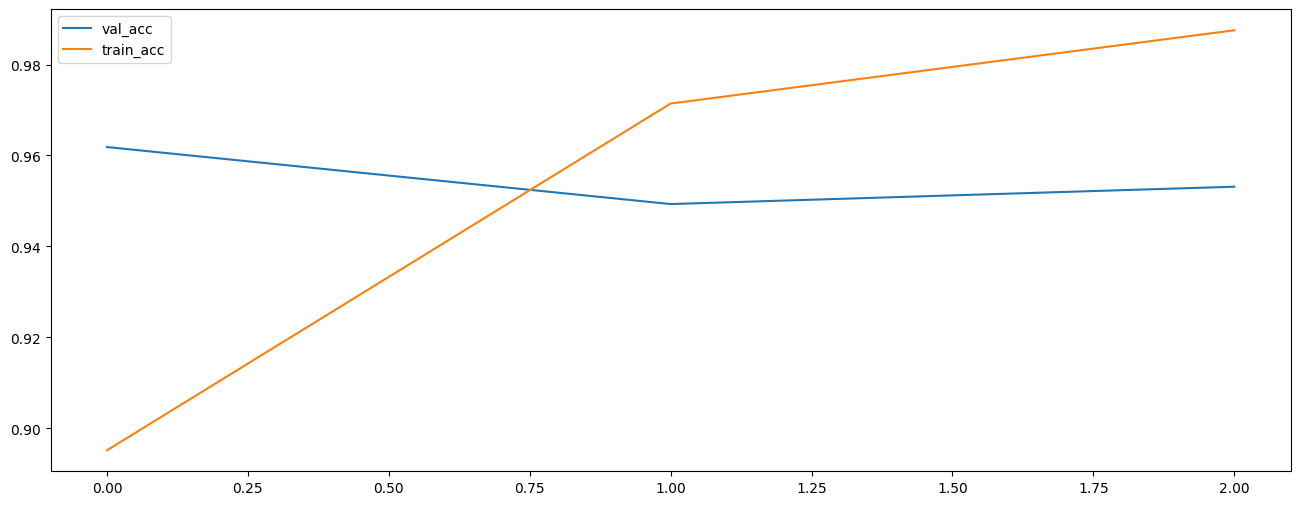

In [ ]:
plt.figure(figsize=(16,6))
plt.plot(hist.history['val_acc'], label='val_acc')
plt.plot(hist.history['acc'], label='train_acc')
plt.legend()
plt.show()

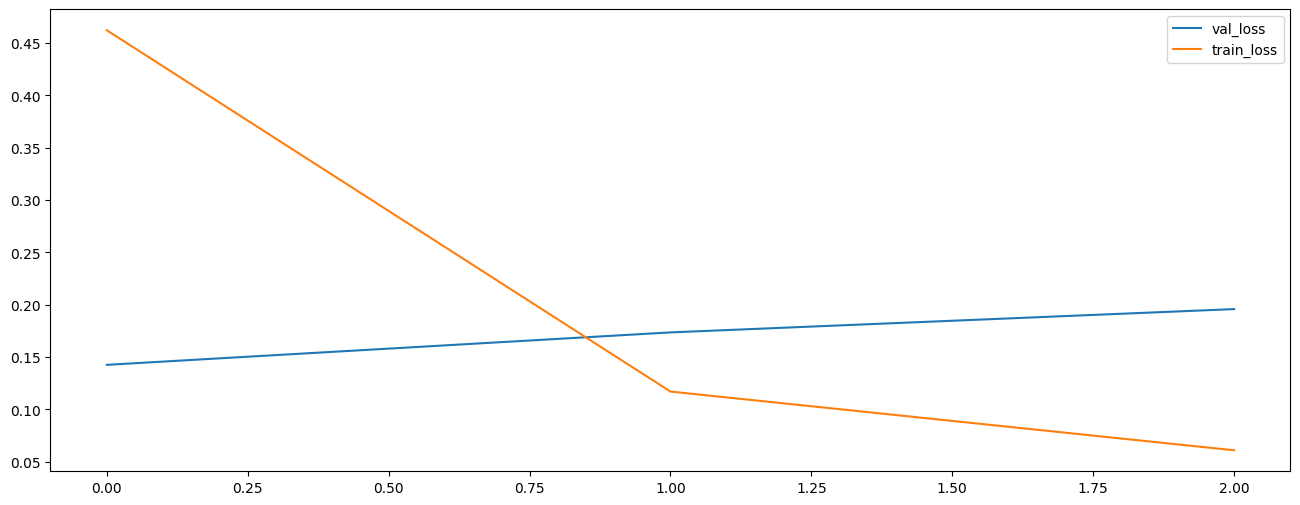

In [ ]:
plt.figure(figsize=(16,6))
plt.plot(hist.history['val_loss'], label='val_loss')
plt.plot(hist.history['loss'], label='train_loss')
plt.legend()
plt.show()

In [ ]:
test_pred = cnn_model_old.predict(test_fit)
accuracy_score(np.array(y_test.tolist()), test_pred.round())

287/287 [==============================] - 1s 3ms/step


0.9465998256320837

In [ ]:

report = classification_report(np.array(y_test.tolist()), test_pred.round())
print(report)


              precision    recall  f1-score   support

           0       0.91      0.99      0.95      4900
           1       0.99      0.89      0.94      4276

    accuracy                           0.95      9176
   macro avg       0.95      0.94      0.95      9176
weighted avg       0.95      0.95      0.95      9176



[[4875   25]
 [ 465 3811]]


<Axes: >

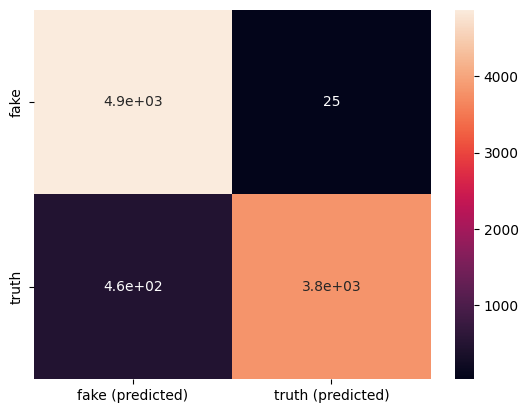

In [ ]:
matrix = confusion_matrix(np.array(y_test.tolist()), test_pred.round())
print(matrix)

#Plot
df_cm = pd.DataFrame(matrix, columns=['fake (predicted)', 'truth (predicted)'], index=['fake', 'truth'])
sns.heatmap(df_cm, annot=True)

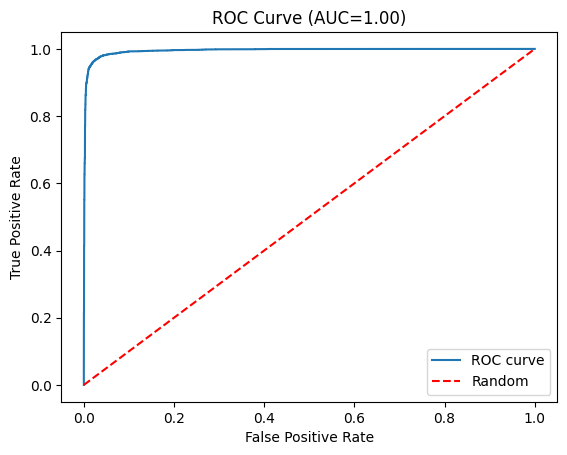

In [ ]:
# Convert true labels to binary format
y_binary = (y_test > 0).astype(int)

# Calculate ROC curve and AUC
fpr, tpr, thresholds = metrics.roc_curve(y_binary, test_pred)
auc = metrics.roc_auc_score(y_binary, test_pred)

# Plot ROC curve
fig, ax = plt.subplots()
ax.set_title('ROC Curve (AUC={:.2f})'.format(auc))
ax.plot(fpr, tpr, label='ROC curve')
ax.plot([0, 1], [0, 1], 'r--', label='Random')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend(loc='lower right')
plt.show()

# **With the Bayesian Optimization parameters (new CNN model)**

#Optimum params for CNN network
params_cnn = {

>
    'lr': 0.007112020384325484,
    'momentum': 0.8922306516546425,
    'dropout1': 0.45425308114898033,
    'dropout2': 0.3925741186212217,
    'filters1Title': 103,
    'denseTitle': 117,
    'filtersContent': 183,
    'denseContent': 104
}

In [ ]:

#input_title
title_input = keras.layers.Input(shape=(len_title,), name='title_input')
inp = keras.layers.Embedding(output_dim=300, input_dim=50000,
                         weights=[embed_mat], trainable=False, name='embed_title')(title_input)

x = keras.layers.Conv1D(filters = 103, kernel_size=4, strides=2, activation='relu', name='Conv1Title')(inp)
x = keras.layers.MaxPool1D(pool_size = 2, name='Pool1Title')(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(117, activation='relu', name='Dense1Title', kernel_regularizer='l2')(x)

#input_content
content_input = keras.layers.Input(shape=(len_text,), name='content_input')
inp2 = keras.layers.Embedding(output_dim=300, input_dim=50000,
                         weights=[embed_mat], trainable=False, name='embed_content')(content_input)
x2 = keras.layers.Conv1D(filters = 183, kernel_size = 16, strides = 2, activation='relu', name='Conv1Content')(inp2)
x2 = keras.layers.MaxPool1D(pool_size = 6, name='Pool1Content')(x2)

#Added
x2 = keras.layers.Conv1D(filters = 80, kernel_size = 8, strides = 4, activation='relu', name='Conv2Content')(inp2)
x2 = keras.layers.MaxPool1D(pool_size = 2, name='Pool2Content')(x2)
#

x2 = keras.layers.Flatten()(x2)
x2 = keras.layers.Dense(104, activation='relu', kernel_regularizer='l2', name='Dense1Content')(x2)


#Merge
x = keras.layers.concatenate([x, x2])

#Common part
x = keras.layers.Dense(100, activation='relu')(x)
x = keras.layers.Dropout(0.45425308114898033)(x)
x = keras.layers.Dense(50, activation='relu')(x)
x = keras.layers.Dropout(0.3925741186212217)(x)
out = keras.layers.Dense(1, activation='sigmoid')(x)


#Build model
cnn_model_new = keras.models.Model(inputs=[title_input, content_input], outputs=[out])

# Default learning rate is 0.001
cnn_model_new.compile(keras.optimizers.SGD(learning_rate = 0.007112020384325484, momentum= 0.8922306516546425),
                  loss=binary_crossentropy, metrics=['acc'])

cnn_model_new.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 title_input (InputLayer)       [(None, 12)]         0           []                               
                                                                                                  
 content_input (InputLayer)     [(None, 523)]        0           []                               
                                                                                                  
 embed_title (Embedding)        (None, 12, 300)      15000000    ['title_input[0][0]']            
                                                                                                  
 embed_content (Embedding)      (None, 523, 300)     15000000    ['content_input[0][0]']          
                                                                                            

The code snippet you provided trains the compiled model using the `fit()` function. Here's a breakdown of the arguments and their purpose:

- `x=train_fit`: The input data for training, which consists of the title and content inputs. `train_fit` is a list containing the numpy arrays for the title and content inputs.

- `y=np.asarray(y_train.tolist())`: The target labels for training, converted to a numpy array.

- `batch_size=128`: The number of samples per gradient update. The training data will be divided into batches of size 128.

- `epochs=20`: The number of times the entire training dataset will be iterated over during training.

- `callbacks=[k.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.1)]`: A list of callbacks to be applied during training. In this case, it includes an EarlyStopping callback, which monitors the validation loss and stops training if the loss does not improve for 3 consecutive epochs, considering a minimum change of 0.1 as an improvement.

- `validation_data=(valid_fit, np.asarray(y_valid.tolist()))`: The validation data to evaluate the model's performance during training. It consists of the title and content inputs for the validation set (`valid_fit`) and the corresponding target labels converted to a numpy array.

The `fit()` function trains the model using the provided training data, target labels, and other specified parameters. The training progress, including loss and accuracy, will be displayed during training. The returned `hist` variable likely holds information about the training history, such as the loss and accuracy values at each epoch.

In [ ]:
hist = cnn_model_new.fit(x=train_fit, y=np.asarray(y_train.tolist()), batch_size=128, epochs=20,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, min_delta = 0.1)],
                 validation_data=(valid_fit, np.asarray(y_valid.tolist())))

Epoch 1/20
259/259 [==============================] - 5s 15ms/step - loss: 3.1253 - acc: 0.7322 - val_loss: 2.0247 - val_acc: 0.9234
Epoch 2/20
259/259 [==============================] - 3s 12ms/step - loss: 1.4936 - acc: 0.9478 - val_loss: 1.0439 - val_acc: 0.9556
Epoch 3/20
259/259 [==============================] - 3s 12ms/step - loss: 0.7799 - acc: 0.9688 - val_loss: 0.5714 - val_acc: 0.9654
Epoch 4/20
259/259 [==============================] - 3s 12ms/step - loss: 0.4142 - acc: 0.9820 - val_loss: 0.3478 - val_acc: 0.9659
Epoch 5/20
259/259 [==============================] - 3s 12ms/step - loss: 0.2283 - acc: 0.9883 - val_loss: 0.2437 - val_acc: 0.9662
Epoch 6/20
259/259 [==============================] - 3s 13ms/step - loss: 0.1380 - acc: 0.9906 - val_loss: 0.1589 - val_acc: 0.9763
Epoch 7/20
259/259 [==============================] - 3s 12ms/step - loss: 0.0899 - acc: 0.9931 - val_loss: 0.1479 - val_acc: 0.9687


In [ ]:
cnn_model_new.save('/content/drive/Shareddrives/DS4A_Fakenews/notebook/model/new_cnn_model.h5')

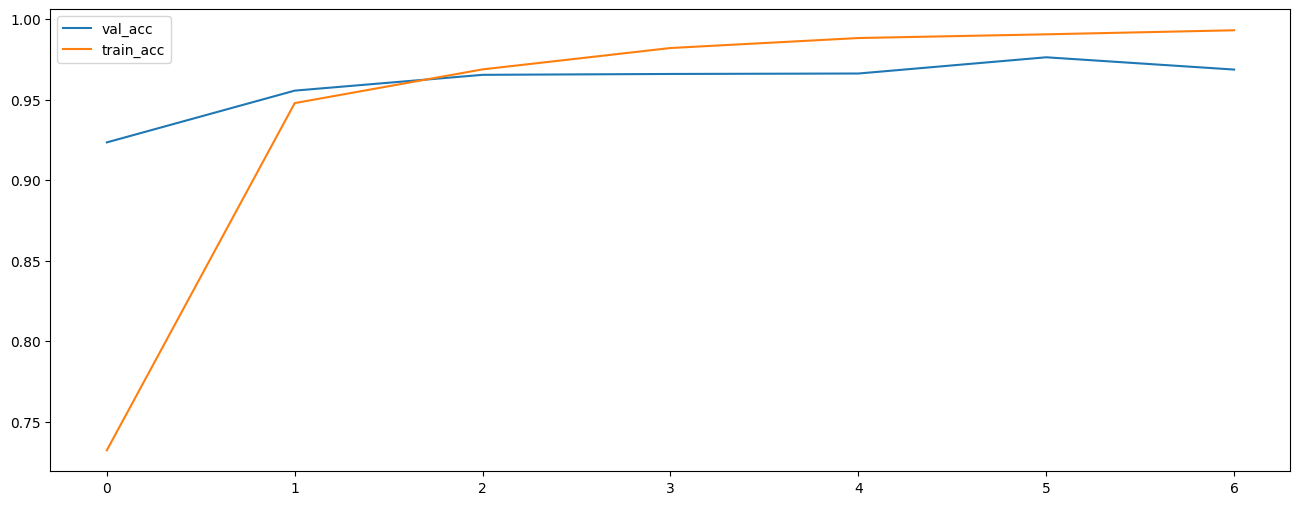

In [ ]:

plt.figure(figsize=(16,6))
plt.plot(hist.history['val_acc'], label='val_acc')
plt.plot(hist.history['acc'], label='train_acc')
plt.legend()
plt.show()

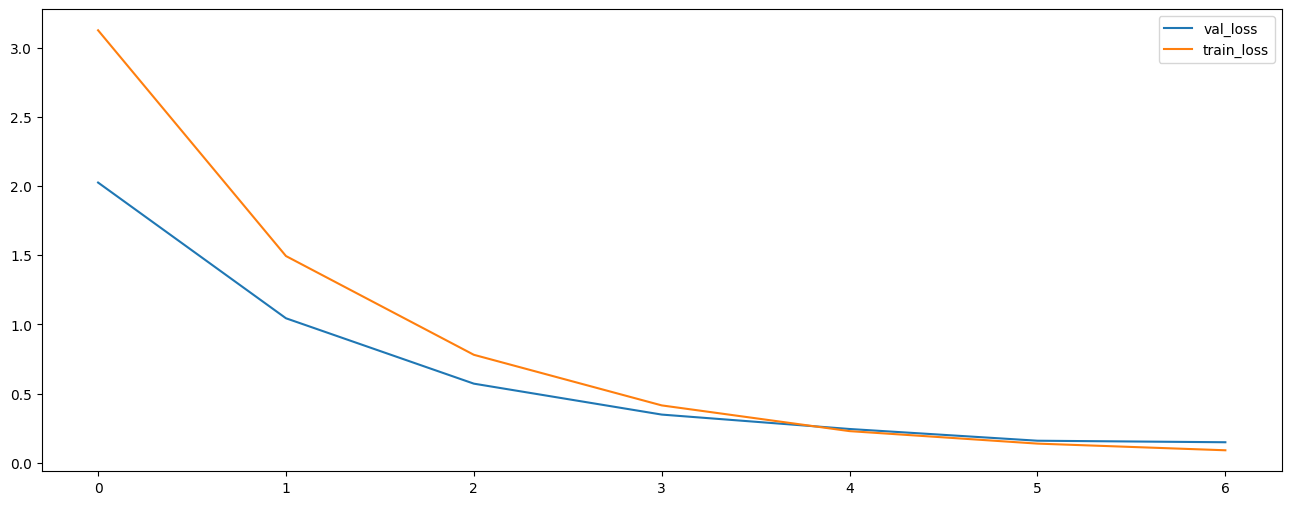

In [ ]:
plt.figure(figsize=(16,6))
plt.plot(hist.history['val_loss'], label='val_loss')
plt.plot(hist.history['loss'], label='train_loss')
plt.legend()
plt.show()

In [ ]:
test_pred = cnn_model_new.predict(test_fit)
accuracy_score(np.array(y_test.tolist()), test_pred.round())

287/287 [==============================] - 1s 3ms/step


0.9761333914559721

In [ ]:

report = classification_report(np.array(y_test.tolist()), test_pred.round())
print(report)


              precision    recall  f1-score   support

           0       0.97      0.98      0.98      4900
           1       0.98      0.97      0.97      4276

    accuracy                           0.98      9176
   macro avg       0.98      0.98      0.98      9176
weighted avg       0.98      0.98      0.98      9176



[[4822   78]
 [ 141 4135]]


<Axes: >

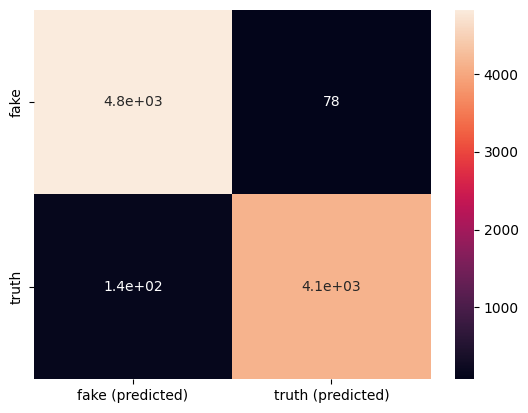

In [ ]:
matrix = confusion_matrix(np.array(y_test.tolist()), test_pred.round())
print(matrix)

#Plot
df_cm = pd.DataFrame(matrix, columns=['fake (predicted)', 'truth (predicted)'], index=['fake', 'truth'])
sns.heatmap(df_cm, annot=True)

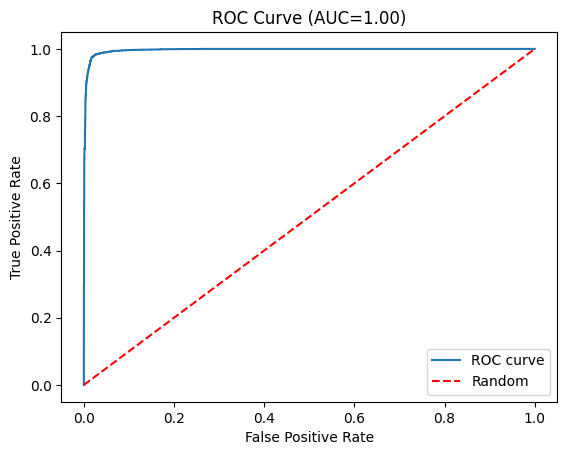

In [ ]:
# Convert true labels to binary format
y_binary = (y_test > 0).astype(int)

# Calculate ROC curve and AUC
fpr, tpr, thresholds = metrics.roc_curve(y_binary, test_pred)
auc = metrics.roc_auc_score(y_binary, test_pred)

# Plot ROC curve
fig, ax = plt.subplots()
ax.set_title('ROC Curve (AUC={:.2f})'.format(auc))
ax.plot(fpr, tpr, label='ROC curve')
ax.plot([0, 1], [0, 1], 'r--', label='Random')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend(loc='lower right')
plt.show()


# **Retrain the model with all data (train + validatin + test)**

This is the original train, validation, testing data percentage, now we are going to use all data to train the model with Bayesian parameters.

test :20% <br>
train: 72% <br>
validation: 8%

In [ ]:
new_cnn_model = load_model('/content/drive/Shareddrives/DS4A_Fakenews/notebook/model/new_cnn_model.h5')

In [ ]:
retrain_cnn_model = new_cnn_model

In [ ]:
all_X_title = df["vectorized_title"]
all_X_text = df["vectorized_clean_text"]
y_test = df["one_hot_label"]

In [ ]:
all_X_data = [np.asarray(all_X_title.tolist()),
             np.asarray(all_X_text.tolist())]


In [ ]:
retrain_cnn_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 title_input (InputLayer)       [(None, 12)]         0           []                               
                                                                                                  
 content_input (InputLayer)     [(None, 523)]        0           []                               
                                                                                                  
 embed_title (Embedding)        (None, 12, 300)      15000000    ['title_input[0][0]']            
                                                                                                  
 embed_content (Embedding)      (None, 523, 300)     15000000    ['content_input[0][0]']          
                                                                                            

In [ ]:
all_y_data

array([[array([0])],
       [array([0])],
       [array([0])],
       ...,
       [array([1])],
       [array([1])],
       [array([1])]], dtype=object)

In [ ]:
# Assuming all_y_data is a numpy array containing arrays with binary labels (0 or 1)
# Extract the numerical labels and convert to integers
all_y_data_int = np.asarray([label[0][0] for label in all_y_data])


In [ ]:
all_y_data_int

array([0, 0, 0, ..., 1, 1, 1])

In [ ]:
all_X_data

[array([[ 339,  151, 2647, ...,    0,    0,    0],
        [ 445, 8507, 7490, ...,    0,    0,    0],
        [ 474,   65, 4030, ...,    0,    0,    0],
        ...,
        [3189, 6468, 2540, ...,    0,    0,    0],
        [7998, 2139, 8000, ...,    0,    0,    0],
        [ 753,  214, 1069, ...,    0,    0,    0]]),
 array([[23764,  3343,  6333, ...,     0,     0,     0],
        [23764,  3343,  6333, ...,     0,     0,     0],
        [ 5682,   749,   696, ...,   486,    56,   915],
        ...,
        [ 8060,  6992,  1482, ...,     0,     0,     0],
        [ 2175,   111, 23955, ...,     0,     0,     0],
        [  753,  6733,  9111, ...,     0,     0,     0]])]

In [ ]:
hist = retrain_cnn_model.fit(x = all_X_data, y= all_y_data_int, batch_size=128, epochs=8)

Epoch 1/8
359/359 [==============================] - 5s 11ms/step - loss: 0.0834 - acc: 0.9875
Epoch 2/8
359/359 [==============================] - 4s 12ms/step - loss: 0.0502 - acc: 0.9934
Epoch 3/8
359/359 [==============================] - 4s 11ms/step - loss: 0.0363 - acc: 0.9960
Epoch 4/8
359/359 [==============================] - 4s 11ms/step - loss: 0.0326 - acc: 0.9961
Epoch 5/8
359/359 [==============================] - 4s 11ms/step - loss: 0.0243 - acc: 0.9982
Epoch 6/8
359/359 [==============================] - 4s 11ms/step - loss: 0.0196 - acc: 0.9982
Epoch 7/8
359/359 [==============================] - 4s 11ms/step - loss: 0.0270 - acc: 0.9965
Epoch 8/8
359/359 [==============================] - 4s 11ms/step - loss: 0.0212 - acc: 0.9982


In [ ]:
retrain_cnn_model.save('/content/drive/Shareddrives/DS4A_Fakenews/notebook/model/retrain_cnn_model.h5')

------------------------------------------------------------------------------